<div class="alert alert-block alert-success">
<b>Good: </b>Scenario analysis
</div>

In [15]:
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

def time_to_minutes(t):
    h, m = map(int, t.split(':'))
    return h * 60 + m


def calculate_slack_for_scenario(scenario_data):
    """
    Calculate the slack metric for the given scenario.
    
    Slack is defined as:
        Slack = 1 - (total flight minutes in recovery period / total recovery period aircraft-minutes)
    
    A slack of 1 means no flights during recovery period.
    A slack of 0 means flights occupy the entire recovery period.
    """
    def time_to_minutes(timestr):
        # timestr format: "HH:MM"
        hh, mm = timestr.split(":")
        return int(hh) * 60 + int(mm)
    
    # Extract scenario start/end times
    # We assume the same date for start and end for simplicity.
    recovery_start_time_str = scenario_data["recovery_start_time"]  
    recovery_end_time_str = scenario_data["recovery_end_time"]      
    
    recovery_start_minutes = time_to_minutes(recovery_start_time_str)
    recovery_end_minutes = time_to_minutes(recovery_end_time_str)
    total_recovery_period_minutes = recovery_end_minutes - recovery_start_minutes
    
    total_aircraft = scenario_data["total_aircraft"]
    
    # Calculate total flight minutes within the recovery period
    flights = scenario_data["flights"]
    total_flight_minutes_in_recovery = 0
    
    for flight_id, flight_data in flights.items():
        dep_time_str = flight_data["DepTime"]  
        arr_time_str = flight_data["ArrTime"] 
        
        dep_minutes = time_to_minutes(dep_time_str)
        arr_minutes = time_to_minutes(arr_time_str)
        
        
        overlap_start = max(dep_minutes, recovery_start_minutes)
        overlap_end = min(arr_minutes, recovery_end_minutes)
        
        if overlap_end > overlap_start:
            flight_overlap = overlap_end - overlap_start
        else:
            flight_overlap = 0
        
        total_flight_minutes_in_recovery += flight_overlap
    
    # Calculate total aircraft-minutes available during the recovery period
    total_recovery_aircraft_minutes = total_recovery_period_minutes * total_aircraft
    
    # Slack calculation
    if total_recovery_aircraft_minutes == 0:
        slack = 1.0
    else:
        slack = 1 - (total_flight_minutes_in_recovery / total_recovery_aircraft_minutes)
    
    return slack


def extract_disruption_stats(scenario_data):
    """
    Extract disruption statistics:
    - Count of fully disrupted (prob = 1.0)
    - Count of uncertain disruptions (0 < prob < 1.0)
    - Average probability across all aircraft (where an aircraft's probability is the max disruption probability it faces, 
      with 1.0 for fully disrupted and 0.0 if no disruption)
    - Average uncertainty probability (average of all disruptions where 0<prob<1.0, excluding 0 and 1)
    """
    disruptions_info = scenario_data.get('disruptions', {})
    disruptions_list = disruptions_info.get('disruptions', [])
    total_aircraft = disruptions_info.get('total_aircraft', 0)

    if total_aircraft == 0:
        # No aircraft or no disruptions
        return 0, 0, 0.0, 0.0

    fully_disrupted_count = sum(1 for d in disruptions_list if d.get('probability', 0.0) == 1.0)
    uncertain_disruptions = [d for d in disruptions_list if 0.0 < d.get('probability', 0.0) < 1.0]
    uncertain_count = len(uncertain_disruptions)

    aircraft_ids = scenario_data.get('aircraft_ids', [])
    ac_prob_map = {ac: 0.0 for ac in aircraft_ids}  
    
    for d in disruptions_list:
        ac_id = d.get('aircraft_id')
        p = d.get('probability', 0.0)
        # Keep the max probability for that aircraft
        if ac_id in ac_prob_map:
            ac_prob_map[ac_id] = max(ac_prob_map[ac_id], p)

    avg_ac_prob = sum(ac_prob_map.values()) / total_aircraft if total_aircraft > 0 else 0.0

    # Average uncertainty probability (only consider disruptions where 0<prob<1)
    if len(uncertain_disruptions) > 0:
        avg_uncertainty_prob = np.mean([d['probability'] for d in uncertain_disruptions])
    else:
        avg_uncertainty_prob = 0.0

    return fully_disrupted_count, uncertain_count, avg_ac_prob, avg_uncertainty_prob

# Path to the scenarios folder
scenario_folder_path = "../logs/scenarios/"
latest_folder = max(
    [f for f in os.listdir(scenario_folder_path) if f.startswith("scenario_folder_")],
    key=lambda x: int(x.split('_')[-1].replace('.json', ''))
)

latest_folder = "scenario_folder_scenario_2.json"

file_path = os.path.join(scenario_folder_path, latest_folder)

# Extract scenario ID
scenario_id = file_path.split('_')[-1].split('.')[0]
print(f"Scenario ID: {scenario_id}")

# Load the JSON data
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract the scenarios from the JSON data
scenarios = data['outputs']


# Extract the data_folder (not strictly necessary for slack calculation, but we print it for context)
data_folder = data['data_folder']
print(f"Data Folder: {data_folder}")

# Calculate slack and disruption stats for each scenario and store in a list of dicts
results = []
for scenario_name, scenario_data in scenarios.items():
    scenario_slack = calculate_slack_for_scenario(scenario_data)
    fully_disrupted_count, uncertain_count, avg_ac_prob, avg_uncertain_prob = extract_disruption_stats(scenario_data)
    results.append({
        "Scenario": scenario_name,
        "ScenarioSlack": scenario_slack,
        "FullyDisruptedCount": fully_disrupted_count,
        "UncertainCount": uncertain_count,
        "AvgAircraftProbability": avg_ac_prob,
        "AvgUncertaintyProbability": avg_uncertain_prob
    })

# Convert results to DataFrame
scenarios_df = pd.DataFrame(results)
print(scenarios_df)

# Save the slack results to CSV
# output_file = os.path.join(scenario_folder_path, f"scenario_slack_metrics_{scenario_id}.csv")
# scenarios_df.to_csv(output_file, index=False)
# print(f"Slack metrics saved to {output_file}")


Scenario ID: 2
Data Folder: ../data/TEMP/6ac-700-diverse/
                          Scenario  ScenarioSlack  FullyDisruptedCount  \
0    deterministic_na_Scenario_001       0.456566                    2   
1    deterministic_na_Scenario_002       0.431838                    2   
2    deterministic_na_Scenario_003       0.404209                    2   
3    deterministic_na_Scenario_004       0.407562                    2   
4    deterministic_na_Scenario_005       0.441667                    2   
..                             ...            ...                  ...   
695        mixed_high_Scenario_096       0.342424                    1   
696        mixed_high_Scenario_097       0.420000                    1   
697        mixed_high_Scenario_098       0.406130                    1   
698        mixed_high_Scenario_099       0.422569                    1   
699        mixed_high_Scenario_100       0.421732                    1   

     UncertainCount  AvgAircraftProbability  AvgUncer

<div class="alert alert-block alert-success">
<b>Good: </b>Inferencing
</div>

In [16]:
import os
import json
import time
import numpy as np
import pandas as pd
import torch
from datetime import datetime
import time

from stable_baselines3 import DQN
from src.environment import AircraftDisruptionEnv
from scripts.utils import load_scenario_data, NumpyEncoder, get_training_metadata
from scripts.logger import create_new_id, log_inference_metadata, find_corresponding_training_id, convert_to_serializable

def run_inference_dqn_single(model_path, scenario_folder, env_type, seed):
    """
    Runs inference on a single scenario and returns the total reward.
    """
    start_time = time.time()
    data_dict = load_scenario_data(scenario_folder)
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    env = AircraftDisruptionEnv(
        aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict, env_type=env_type
    )

    model = DQN.load(model_path)
    model.set_env(env)
    model.policy.set_training_mode(False)
    model.exploration_rate = 0.0

    # Set seeds for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)

    obs, _ = env.reset()
    done_flag = False
    total_reward = 0
    step_num = 0
    max_steps = 1000

    while not done_flag and step_num < max_steps:
        action_mask = obs['action_mask']
        obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}
        obs_tensor = model.policy.obs_to_tensor(obs)[0]
        q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()

        masked_q_values = q_values.copy()
        masked_q_values[action_mask == 0] = -np.inf

        # If no valid actions remain, break out
        if np.all(np.isinf(masked_q_values)):
            break

        action = np.argmax(masked_q_values)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        done_flag = terminated or truncated
        step_num += 1

    total_delays = env.scenario_wide_delay_minutes
    total_cancelled_flights = env.scenario_wide_cancelled_flights
    end_time = time.time()
    scenario_time = end_time - start_time
    scenario_steps = env.scenario_wide_steps
    scenario_resolved_conflicts = env.scenario_wide_resolved_conflicts
    solution_slack = env.scenario_wide_solution_slack
    scenario_wide_tail_swaps = env.scenario_wide_tail_swaps
    scenario_wide_actual_disrupted_flights = env.scenario_wide_actual_disrupted_flights
    scenario_wide_reward_components = env.scenario_wide_reward_components

    return total_reward, total_delays, total_cancelled_flights, scenario_time, scenario_steps, scenario_resolved_conflicts, solution_slack, scenario_wide_tail_swaps, scenario_wide_actual_disrupted_flights, scenario_wide_reward_components

def run_inference_on_data_folder(model_paths, data_folder, seeds):
    """
    Runs inference on all scenarios found in 'data_folder', for each model in 'model_paths' and each seed in 'seeds'.

    Args:
        model_paths (list): List of model paths to run inference with.
        data_folder (str): Path to the folder containing scenario subfolders.
        env_type (str): Type of environment ("myopic", "proactive", "reactive").
        seeds (list): List of seeds for reproducibility.

    Returns:
        pd.DataFrame: A DataFrame containing scenario, model, seed, and total reward.
    """

    # Identify all scenario folders within data_folder
    scenario_folders = [
        os.path.join(data_folder, folder)
        for folder in os.listdir(data_folder)
        if os.path.isdir(os.path.join(data_folder, folder))
    ]

    results = []
    for scenario_folder in scenario_folders:
        scenario_name = os.path.basename(scenario_folder)
        for model_path in model_paths:
            for seed in seeds:
                # extract env_type from model_path
                env_type = model_path.split("/")[-2]
                total_reward, total_delays, total_cancelled_flights, scenario_time, scenario_steps, scenario_resolved_conflicts, solution_slack, scenario_wide_tail_swaps, scenario_wide_actual_disrupted_flights, scenario_wide_reward_components = run_inference_dqn_single(model_path, scenario_folder, env_type, seed)
                results.append({
                    "Scenario": scenario_name,
                    "Model": os.path.basename(model_path),
                    "Seed": seed,
                    "TotalReward": total_reward,
                    "TotalDelays": total_delays,
                    "TotalCancelledFlights": total_cancelled_flights,
                    "ScenarioTime": scenario_time,
                    "ScenarioSteps": scenario_steps,
                    "ScenarioResolvedConflicts": scenario_resolved_conflicts,
                    "SolutionSlack": solution_slack,
                    "TailSwaps": scenario_wide_tail_swaps,
                    "ActualDisruptedFlights": scenario_wide_actual_disrupted_flights,
                    "Reward_delay_penalty_total": scenario_wide_reward_components["delay_penalty_total"],
                    "Reward_cancel_penalty": scenario_wide_reward_components["cancel_penalty"],
                    "Reward_inaction_penalty": scenario_wide_reward_components["inaction_penalty"],
                    "Reward_proactive_bonus": scenario_wide_reward_components["proactive_bonus"],
                    "Reward_time_penalty": scenario_wide_reward_components["time_penalty"],
                    "Reward_final_conflict_resolution_reward": scenario_wide_reward_components["final_conflict_resolution_reward"]
                })

    results_df = pd.DataFrame(results)
    return results_df


# Load the JSON data
with open(file_path, 'r') as file:
    data = json.load(file)

data_folder = data['data_folder']
print(f"inferencing on data folder: {data_folder}")

# Define models and seeds 
model_paths = [
    # "../trained_models/dqn/6ac-700-diverse/23/proactive-training_33.zip",
    "../trained_models/dqn/6ac-700-diverse/71/myopic-training_59.zip",
    "../trained_models/dqn/6ac-700-diverse/71/proactive-training_60.zip",
    "../trained_models/dqn/6ac-700-diverse/71/reactive-training_61.zip"
]
seeds = [25, 26, 27]
# approx 1,25min per seed with 3 models

results_df = run_inference_on_data_folder(model_paths, data_folder, seeds)



inferencing on data folder: ../data/TEMP/6ac-700-diverse/


<div class="alert alert-block alert-success">
<b>Good: </b>Merging scenario data and inference data
</div>

In [17]:
# Merge scenario-level info from scenarios_df into results_df
merged_df = results_df.merge(scenarios_df, on='Scenario', how='left')

print("Inference Results (After Merging):")
print(merged_df.head(20))

# Save the merged results to CSV
merged_output_file = os.path.join(scenario_folder_path, f"scenario_inference_metrics_{scenario_id}.csv")
merged_df.to_csv(merged_output_file, index=False)
print(f"Inference results with scenario info saved to {merged_output_file}")

# print all column names
print(results_df.columns)



Inference Results (After Merging):
                        Scenario                      Model  Seed  \
0      mixed_medium_Scenario_015     myopic-training_59.zip    25   
1      mixed_medium_Scenario_015     myopic-training_59.zip    26   
2      mixed_medium_Scenario_015     myopic-training_59.zip    27   
3      mixed_medium_Scenario_015  proactive-training_60.zip    25   
4      mixed_medium_Scenario_015  proactive-training_60.zip    26   
5      mixed_medium_Scenario_015  proactive-training_60.zip    27   
6      mixed_medium_Scenario_015   reactive-training_61.zip    25   
7      mixed_medium_Scenario_015   reactive-training_61.zip    26   
8      mixed_medium_Scenario_015   reactive-training_61.zip    27   
9         mixed_low_Scenario_077     myopic-training_59.zip    25   
10        mixed_low_Scenario_077     myopic-training_59.zip    26   
11        mixed_low_Scenario_077     myopic-training_59.zip    27   
12        mixed_low_Scenario_077  proactive-training_60.zip    25   

<div class="alert alert-block alert-info">
<b>Check: </b>Comparison of Models Across All Scenarios
</div>

In [18]:
import pandas as pd

comparison_table = (
    merged_df
    .groupby('Model')
    .agg(
        Mean_Reward=('TotalReward', 'mean'),
        Mean_Runtime=('ScenarioTime', 'mean'),
        Mean_Steps=('ScenarioSteps', 'mean'),
        Mean_Delays=('TotalDelays', 'mean'),
        Mean_CancelledFlights=('TotalCancelledFlights', 'mean'),
    )
    .round(2)
)

print("Comparison of Models Across All Scenarios:")
print(comparison_table)


Comparison of Models Across All Scenarios:
                           Mean_Reward  Mean_Runtime  Mean_Steps  Mean_Delays  \
Model                                                                           
myopic-training_59.zip       -13863.37          0.03        8.34         9.74   
proactive-training_60.zip    -12428.93          0.03        8.16        50.49   
reactive-training_61.zip     -11664.25          0.03        7.99        50.98   

                           Mean_CancelledFlights  
Model                                             
myopic-training_59.zip                      2.31  
proactive-training_60.zip                   2.11  
reactive-training_61.zip                    2.06  


In [19]:
import pandas as pd

# Calculate average rewards per scenario-model combination first
scenario_model_avgs = (
    merged_df
    .groupby(['Scenario', 'Model'])['TotalReward']
    .mean()
    .reset_index()
)

# For each scenario, find best and second best models based on average rewards
scenario_rankings = (
    scenario_model_avgs
    .groupby('Scenario')
    .apply(lambda x: pd.Series({
        'best_model': x.loc[x['TotalReward'].idxmax(), 'Model'],
        'best_reward': x['TotalReward'].max(),
        'second_best_reward': x['TotalReward'].nlargest(2).iloc[-1],
        'reward_difference': x['TotalReward'].max() - x['TotalReward'].nlargest(2).iloc[-1]
    }))
)

# Sort by reward difference and get top 5
top_5_differences = scenario_rankings.nlargest(5, 'reward_difference')

print("Top 5 scenarios with largest average performance gap between best and second best model:")
for idx, row in top_5_differences.iterrows():
    print(f"\nScenario: {idx}")
    print(f"Best performing model: {row['best_model']}")
    print(f"Average reward difference: {row['reward_difference']:.2f}")


Top 5 scenarios with largest average performance gap between best and second best model:

Scenario: stochastic_high_Scenario_005
Best performing model: reactive-training_61.zip
Average reward difference: 24005.00

Scenario: mixed_low_Scenario_026
Best performing model: reactive-training_61.zip
Average reward difference: 22782.93

Scenario: deterministic_na_Scenario_066
Best performing model: reactive-training_61.zip
Average reward difference: 20020.00

Scenario: stochastic_high_Scenario_052
Best performing model: reactive-training_61.zip
Average reward difference: 19660.00

Scenario: stochastic_high_Scenario_007
Best performing model: reactive-training_61.zip
Average reward difference: 19436.67


/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_2614/3120566422.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


<div class="alert alert-block alert-info">
<b>Check: </b>Reward components
</div>

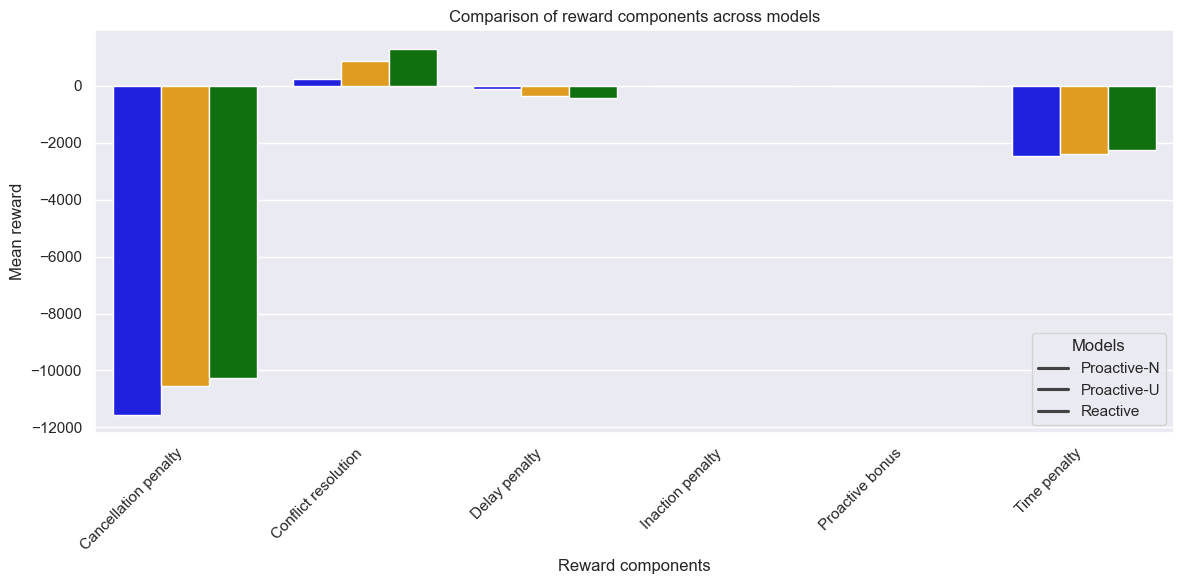

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# Define reward components and their display names
reward_components = [
    'Reward_delay_penalty_total', 
    'Reward_cancel_penalty', 
    'Reward_inaction_penalty', 
    'Reward_proactive_bonus', 
    'Reward_time_penalty', 
    'Reward_final_conflict_resolution_reward'
]

component_display_names = {
    'Reward_delay_penalty_total': 'Delay penalty',
    'Reward_cancel_penalty': 'Cancellation penalty', 
    'Reward_inaction_penalty': 'Inaction penalty',
    'Reward_proactive_bonus': 'Proactive bonus',
    'Reward_time_penalty': 'Time penalty',
    'Reward_final_conflict_resolution_reward': 'Conflict resolution'
}
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else 
        'green',
        'Proactive-U' if 'proactive' in model_name.lower() else
        'Proactive-N' if 'myopic' in model_name.lower() else
        'Reactive'
    )
    for model_name in merged_df['Model'].unique()
}

# Melt the DataFrame to reshape it for bar plotting
melted_df = merged_df.melt(
    id_vars=['Model'], 
    value_vars=reward_components,
    var_name='RewardComponent', 
    value_name='Reward'
)

# Map component names to display names
melted_df['RewardComponent'] = melted_df['RewardComponent'].map(component_display_names)

# Group by Model and RewardComponent to calculate the mean reward values
mean_rewards_df = melted_df.groupby(['Model', 'RewardComponent'], as_index=False).mean()

# Set figure size
plt.figure(figsize=(12, 6))

# Bar plot with custom colors from model_colors
sns.barplot(
    data=mean_rewards_df,
    x='RewardComponent',
    y='Reward',
    hue='Model',
    palette={model: color[0] for model, color in model_colors.items()}
)

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.xlabel("Reward components")
plt.ylabel("Mean reward")
plt.title("Comparison of reward components across models")
plt.legend(title="Models", labels=[color[1] for color in model_colors.values()])
plt.tight_layout()
plt.show()


<div class="alert alert-block alert-warning">
<b>To Do: </b>Impact of scenario slack - improve windows smoothening
</div>

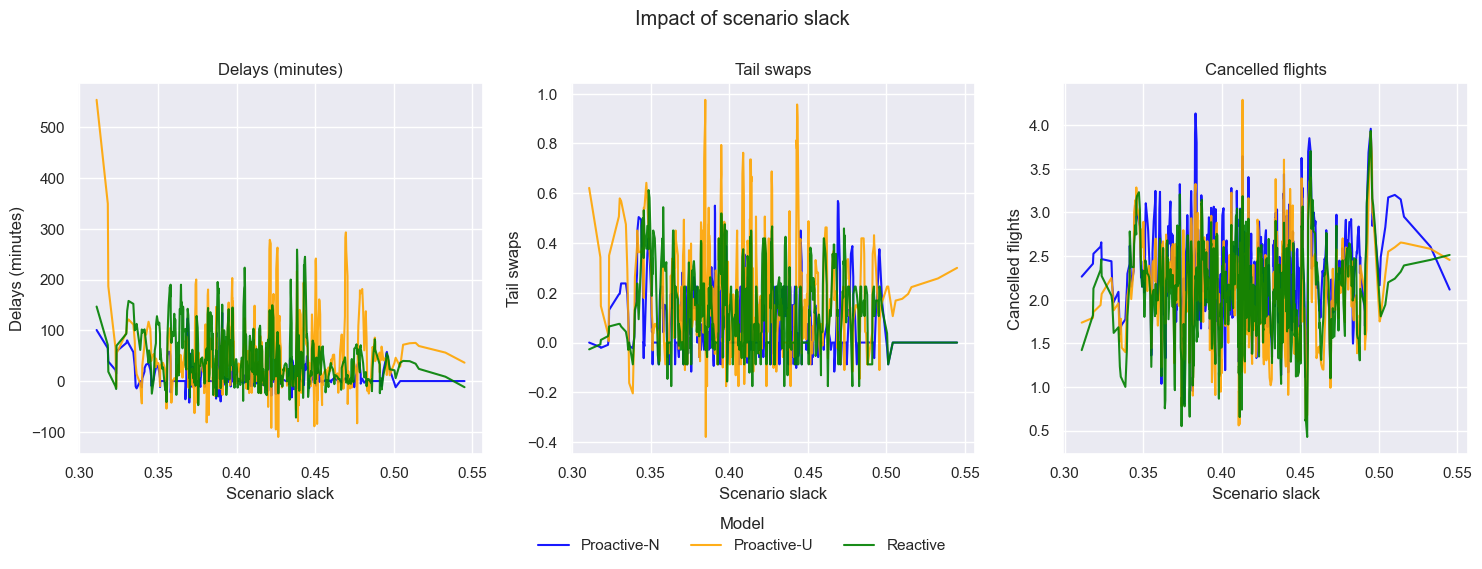

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter

# Define a color map and human-readable labels for the models
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else 
        'green',
        'Proactive-U' if 'proactive' in model_name.lower() else
        'Proactive-N' if 'myopic' in model_name.lower() else
        'Reactive'
    )
    for model_name in merged_df['Model'].unique()
}

# Define the metrics and corresponding y-axis labels
metrics = [
    ("TotalDelays", "Delays (minutes)"),
    ("TailSwaps", "Tail swaps"),
    ("TotalCancelledFlights", "Cancelled flights")
]

# Aggregate data by taking the mean of the numeric metrics for each (Model, ScenarioSlack)
agg_df = (
    merged_df
    .groupby(['Model', 'ScenarioSlack'], as_index=False)[[m[0] for m in metrics]]
    .mean()
)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# Window size for smoothing (must be odd number)
window_size = 10  # Adjust this value to control smoothing amount

for i, (metric, ylabel) in enumerate(metrics):
    ax = axes[i]
    
    # Plot a line for each model
    for model_name, (color, label) in model_colors.items():
        model_data = agg_df[agg_df['Model'] == model_name].copy()
        # Sort by ScenarioSlack for a proper line plot
        model_data = model_data.sort_values(by='ScenarioSlack')
        
        x = model_data['ScenarioSlack']
        y = model_data[metric]
        
        # Only apply smoothing if we have enough data points
        if len(y) >= window_size:
            y_smoothed = savgol_filter(y, window_size, 2)  # 2 is polynomial order
        else:
            y_smoothed = y
            
        ax.plot(
            x,
            y_smoothed,
            label=label, 
            color=color,
            alpha=0.9
        )
        

    
    ax.set_xlabel("Scenario slack")
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.grid(True)

# Add a global legend (once for all subplots)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.03), ncol=3, title="Model", frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Impact of scenario slack", y=1.02)
plt.show()

/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_2614/3586172651.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df


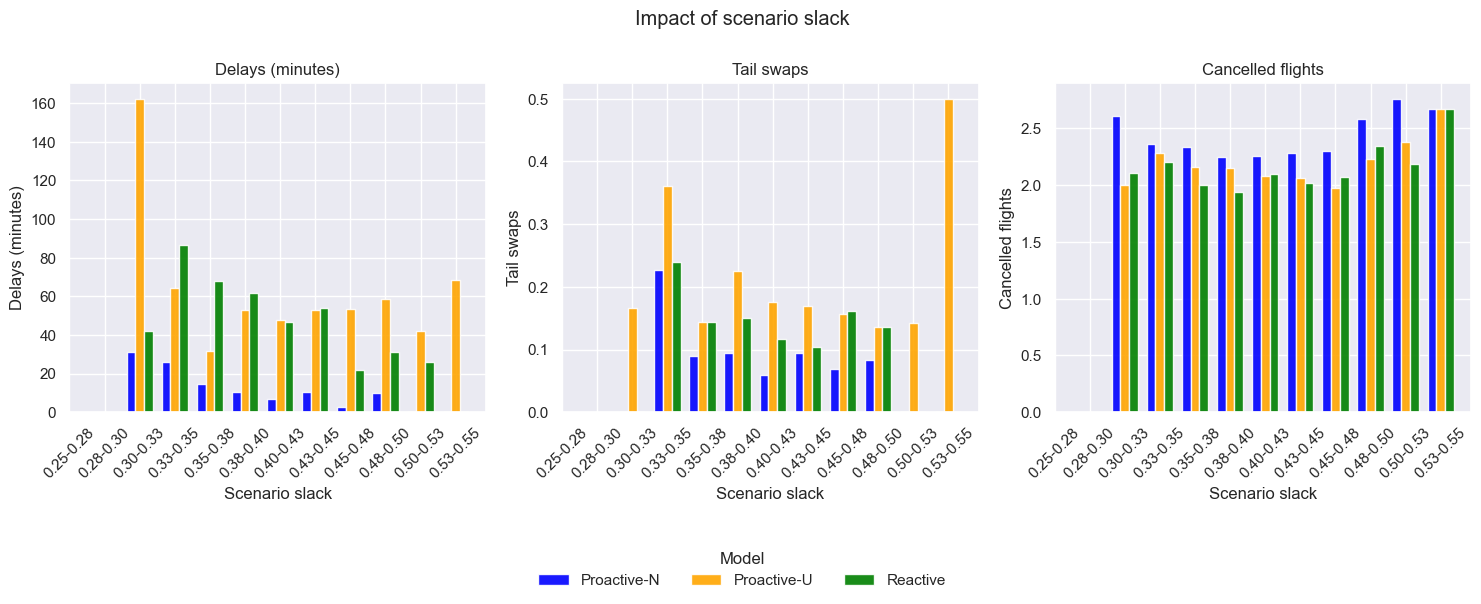

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assume merged_df already exists and has columns 'Model', 'ScenarioSlack', 'TotalDelays', 'TailSwaps', 'TotalCancelledFlights'.
# The code below shows the modification for filtering slack intervals:

# Define a color map and human-readable labels for the models
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else 
        'green',
        'Proactive-U' if 'proactive' in model_name.lower() else
        'Proactive-N' if 'myopic' in model_name.lower() else
        'Reactive'
    )
    for model_name in merged_df['Model'].unique()
}

# Define the metrics and corresponding y-axis labels
metrics = [
    ("TotalDelays", "Delays (minutes)"),
    ("TailSwaps", "Tail swaps"),
    ("TotalCancelledFlights", "Cancelled flights")
]

# Create slack buckets of size 0.05
bucket_size = 0.025
bucket_edges = np.arange(0, 1 + bucket_size, bucket_size)
bucket_labels = [f"{bucket_edges[i]:.2f}-{bucket_edges[i+1]:.2f}" for i in range(len(bucket_edges)-1)]

# Create slack intervals using the defined buckets
merged_df['SlackInterval'] = pd.cut(merged_df['ScenarioSlack'], 
                                    bins=bucket_edges,
                                    labels=bucket_labels,
                                    include_lowest=True)

# Aggregate data by taking the mean of the numeric metrics for each (Model, SlackInterval)
agg_df = (
    merged_df
    .groupby(['Model', 'SlackInterval'], as_index=False)[[m[0] for m in metrics]]
    .mean()
)

# Remove rows where SlackInterval has no actual values
agg_df = agg_df.dropna(subset=['SlackInterval'])

# Define the display range for slack values
display_range = (0.25, 0.55)  # for example, only show intervals between 0.2 and 0.6

# Filter agg_df to only include intervals that lie fully within display_range
def interval_in_range(interval_label, low, high):
    start_str, end_str = interval_label.split('-')
    start_val = float(start_str)
    end_val = float(end_str)
    # Check if the entire interval lies within the specified range
    return start_val >= low and end_val <= high

agg_df = agg_df[agg_df['SlackInterval'].apply(lambda x: interval_in_range(x, display_range[0], display_range[1]))]

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

bar_width = 0.25

# Get only the filtered slack intervals
slack_intervals = sorted(agg_df['SlackInterval'].unique())
x = np.arange(len(slack_intervals))

for i, (metric, ylabel) in enumerate(metrics):
    ax = axes[i]
    
    # Plot bars for each model
    for j, (model_name, (color, label)) in enumerate(model_colors.items()):
        model_data = agg_df[agg_df['Model'] == model_name]
        
        # Align model data with available slack intervals
        model_values = [
            model_data[model_data['SlackInterval'] == interval][metric].iloc[0]
            if not model_data[model_data['SlackInterval'] == interval].empty 
            else 0 
            for interval in slack_intervals
        ]
        
        ax.bar(x + j*bar_width, 
               model_values,
               bar_width,
               label=label,
               color=color,
               alpha=0.9)
    
    ax.set_xlabel("Scenario slack")
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(slack_intervals, rotation=45)
    ax.grid(True, axis='y')

# Add a global legend (once for all subplots)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=3, title="Model", frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Impact of scenario slack", y=1.02)
plt.show()



<div class="alert alert-block alert-success">
<b>Good: </b>Impact of number of disrupted flights
</div>

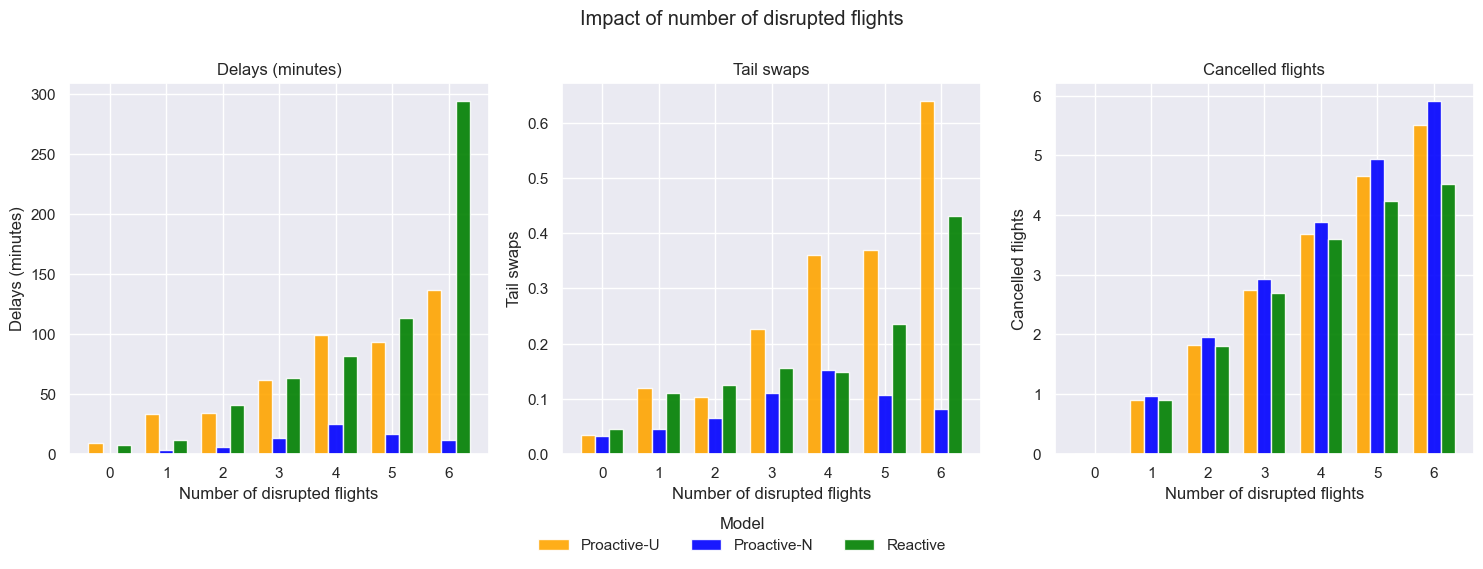

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a color map and human-readable labels for the models
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else 
        'green',
        'Proactive-U' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'Proactive-N' if 'myopic' in model_name.lower() else
        'Reactive'
    )
    for model_name in sorted(merged_df['Model'].unique(), 
                           key=lambda x: (0 if 'proactive' in x.lower() and 'myopic' not in x.lower() else
                                        1 if 'myopic' in x.lower() else 
                                        2))
}

# Define the metrics and corresponding y-axis labels
metrics = [
    ("TotalDelays", "Delays (minutes)"),
    ("TailSwaps", "Tail swaps"), 
    ("TotalCancelledFlights", "Cancelled flights")
]

# Aggregate data by taking the mean of the numeric metrics for each (Model, ActualDisruptedFlights)
agg_df = (
    merged_df
    .groupby(['Model', 'ActualDisruptedFlights'], as_index=False)[[m[0] for m in metrics]]
    .mean()
)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

for i, (metric, ylabel) in enumerate(metrics):
    ax = axes[i]
    
    # Plot bars for each model in the specified order
    bar_offset = -0.25  # Start with leftmost position
    for model_name, (color, label) in model_colors.items():
        model_data = agg_df[agg_df['Model'] == model_name].copy()
        # Sort by ActualDisruptedFlights
        model_data = model_data.sort_values(by='ActualDisruptedFlights')
        
        x = model_data['ActualDisruptedFlights']
        y = model_data[metric]
            
        ax.bar(
            x + bar_offset,  # Offset bars
            y,
            width=0.25,
            label=label,
            color=color,
            alpha=0.9
        )
        bar_offset += 0.25  # Move to next position

    ax.set_xlabel("Number of disrupted flights")
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.grid(True, axis='y')

# Add a global legend (once for all subplots)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.03), ncol=3, title="Model", frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Impact of number of disrupted flights", y=1.02)
plt.show()


<div class="alert alert-block alert-danger">
<b>Irrelevant: </b>Reward vs. AvgUncertaintyProbability (stochastic scenarios)
</div>

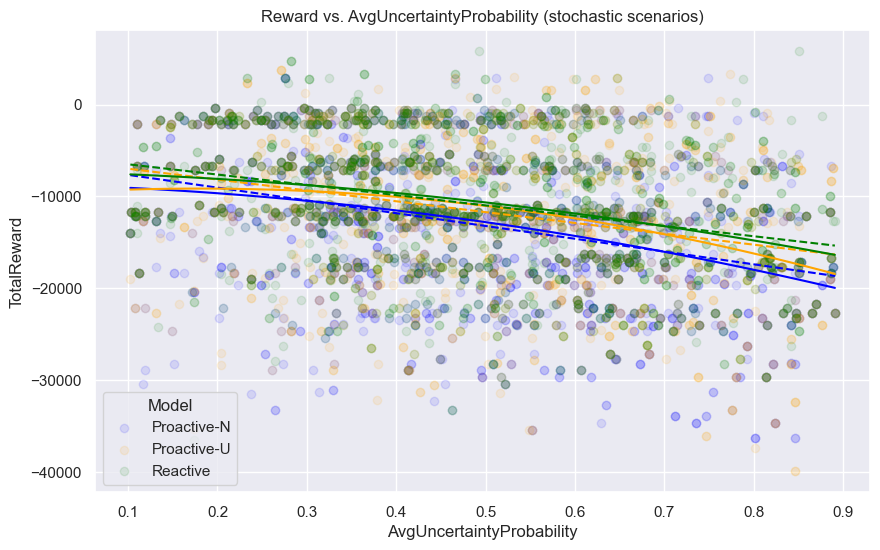

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Filter the DataFrame for stochastic_low, stochastic_medium, and stochastic_high scenarios
filtered_stochastic_df = merged_df[
    merged_df['Scenario'].str.startswith('stochastic_low') |
    merged_df['Scenario'].str.startswith('stochastic_medium') |
    merged_df['Scenario'].str.startswith('stochastic_high') |
    merged_df['Scenario'].str.startswith('mixed_low') |
    merged_df['Scenario'].str.startswith('mixed_medium') |
    merged_df['Scenario'].str.startswith('mixed_high')
]

# Define a color map for the models
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else 
        'green',
        'Proactive-U' if 'proactive' in model_name.lower() else
        'Proactive-N' if 'myopic' in model_name.lower() else
        'Reactive'
    )
    for model_name in filtered_stochastic_df['Model'].unique()
}

plt.figure(figsize=(10, 6))

# Plot each model separately with regression lines
for model_name, (color, label) in model_colors.items():
    model_data = filtered_stochastic_df[filtered_stochastic_df['Model'] == model_name]
    x = model_data['AvgUncertaintyProbability'].values.reshape(-1, 1)
    y = model_data['TotalReward'].values
    
    # Plot scatter points
    plt.scatter(
        x, y,
        c=color,
        label=label,
        alpha=0.1
    )
    
    # Linear regression (degree 1)
    lr = LinearRegression()
    lr.fit(x, y)
    x_pred = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred = lr.predict(x_pred)
    plt.plot(x_pred, y_pred, '--', color=color, alpha=1)
    
    # Polynomial regression (degree 2)
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x)
    lr2 = LinearRegression()
    lr2.fit(x_poly, y)
    x_pred_poly = poly.transform(x_pred)
    y_pred_poly = lr2.predict(x_pred_poly)
    plt.plot(x_pred, y_pred_poly, '-', color=color, alpha=1)

plt.title("Reward vs. AvgUncertaintyProbability (stochastic scenarios)")
plt.xlabel("AvgUncertaintyProbability")
plt.ylabel("TotalReward")
plt.legend(title="Model")
plt.grid(True)
plt.show()


<div class="alert alert-block alert-danger">
<b>Irrelevant: </b>Reward vs. AvgAircraftProbability (all scenarios)
</div>

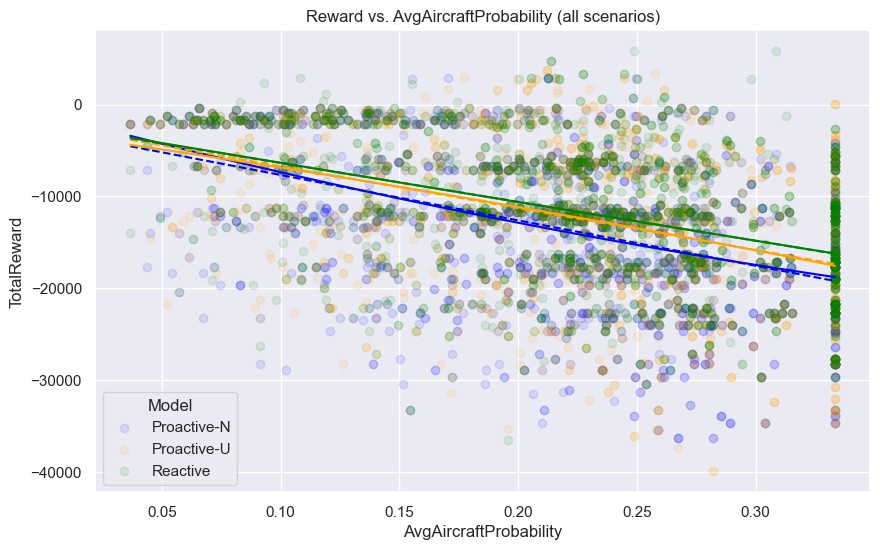

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Define a color map for the models with custom labels
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else 
        'green',
        'Proactive-U' if 'proactive' in model_name.lower() else
        'Proactive-N' if 'myopic' in model_name.lower() else
        'Reactive'
    )
    for model_name in filtered_stochastic_df['Model'].unique()
}

plt.figure(figsize=(10, 6))

# Plot each model separately with regression lines
for model_name, (color, label) in model_colors.items():
    model_data = merged_df[merged_df['Model'] == model_name]
    x = model_data['AvgAircraftProbability'].values.reshape(-1, 1)
    y = model_data['TotalReward'].values
    
    # Plot scatter points
    plt.scatter(
        x, y,
        c=color,
        label=label,
        alpha=0.1
    )
    
    # Linear regression (degree 1)
    lr = LinearRegression()
    lr.fit(x, y)
    x_pred = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred = lr.predict(x_pred)
    plt.plot(x_pred, y_pred, '--', color=color, alpha=1)
    
    # Polynomial regression (degree 2)
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x)
    lr2 = LinearRegression()
    lr2.fit(x_poly, y)
    x_pred_poly = poly.transform(x_pred)
    y_pred_poly = lr2.predict(x_pred_poly)
    plt.plot(x_pred, y_pred_poly, '-', color=color, alpha=1)

plt.title("Reward vs. AvgAircraftProbability (all scenarios)")
plt.xlabel("AvgAircraftProbability")
plt.ylabel("TotalReward")
plt.legend(title="Model")
plt.grid(True)
plt.show()

<div class="alert alert-block alert-danger">
<b>Irrelevant: </b>Reward vs. ScenarioSlack (all scenarios)
</div>

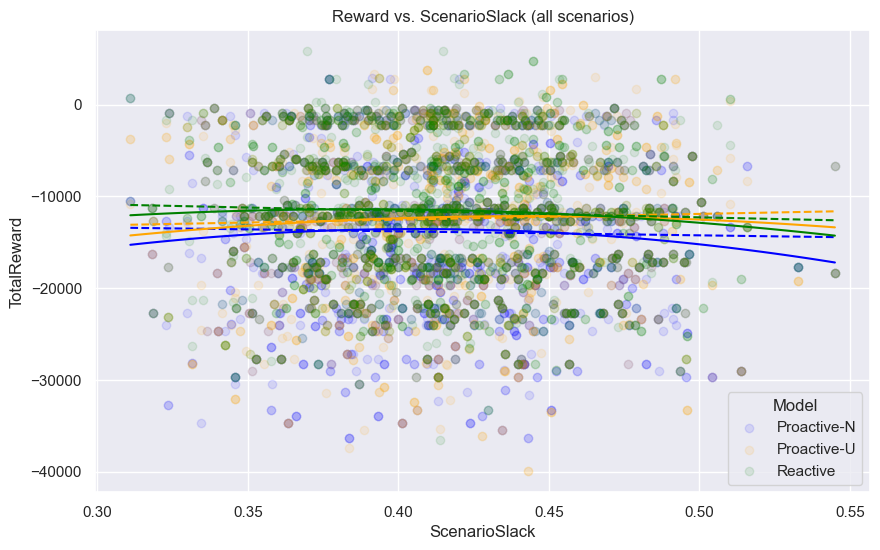

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


plt.figure(figsize=(10, 6))

for model_name, (color, label) in model_colors.items():
    model_data = merged_df[merged_df['Model'] == model_name]
    x = model_data['ScenarioSlack'].values.reshape(-1, 1)
    y = model_data['TotalReward'].values
    
    # Plot scatter points
    plt.scatter(
        x, y,
        c=color,
        label=label,
        alpha=0.1
    )
    
    # Linear regression (degree 1)
    lr = LinearRegression()
    lr.fit(x, y)
    x_pred = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred = lr.predict(x_pred)
    plt.plot(x_pred, y_pred, '--', color=color, alpha=1)
    
    # Polynomial regression (degree 2) for a smoothed curve
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x)
    lr2 = LinearRegression()
    lr2.fit(x_poly, y)
    x_pred_poly = poly.transform(x_pred)
    y_pred_poly = lr2.predict(x_pred_poly)
    plt.plot(x_pred, y_pred_poly, '-', color=color, alpha=1)

plt.title("Reward vs. ScenarioSlack (all scenarios)")
plt.xlabel("ScenarioSlack")
plt.ylabel("TotalReward")
plt.legend(title="Model")
plt.grid(True)
plt.show()


<div class="alert alert-block alert-danger">
<b>Irrelevant: </b>TotalDelay vs. AvgAircraftProbability (all scenarios)
</div>

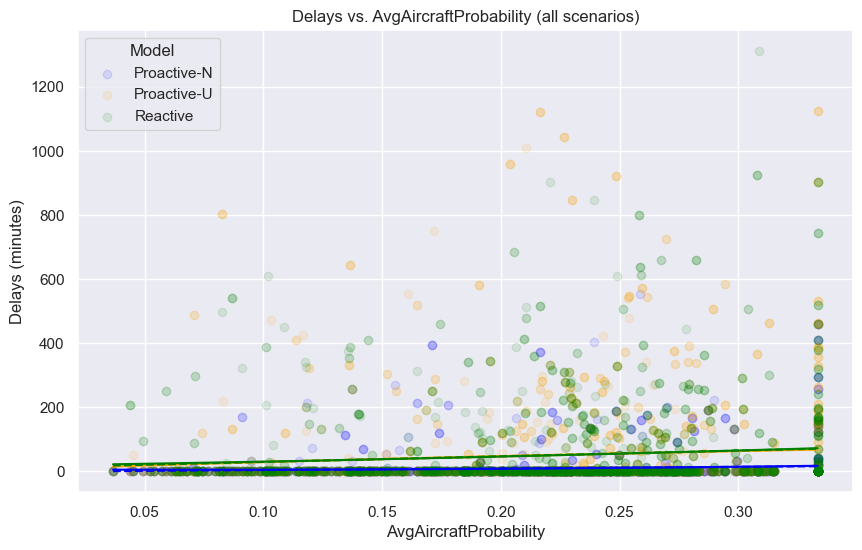

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


plt.figure(figsize=(10, 6))

for model_name, (color, label) in model_colors.items():
    model_data = merged_df[merged_df['Model'] == model_name]
    x = model_data['AvgAircraftProbability'].values.reshape(-1, 1)
    y = model_data['TotalDelays'].values
    
    # Plot scatter points
    plt.scatter(
        x, y,
        c=color,
        label=label,
        alpha=0.1
    )
    
    # Linear regression (degree 1)
    lr = LinearRegression()
    lr.fit(x, y)
    x_pred = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred = lr.predict(x_pred)
    plt.plot(x_pred, y_pred, '--', color=color, alpha=1)
    
    # Polynomial regression (degree 2) for a smoothed curve
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x)
    lr2 = LinearRegression()
    lr2.fit(x_poly, y)
    x_pred_poly = poly.transform(x_pred)
    y_pred_poly = lr2.predict(x_pred_poly)
    plt.plot(x_pred, y_pred_poly, '-', color=color, alpha=1)

plt.title("Delays vs. AvgAircraftProbability (all scenarios)")
plt.xlabel("AvgAircraftProbability")
plt.ylabel("Delays (minutes)")
plt.legend(title="Model")
plt.grid(True)
plt.show()


<div class="alert alert-block alert-danger">
<b>Irrelevant: </b>Plot too unclear
</div>

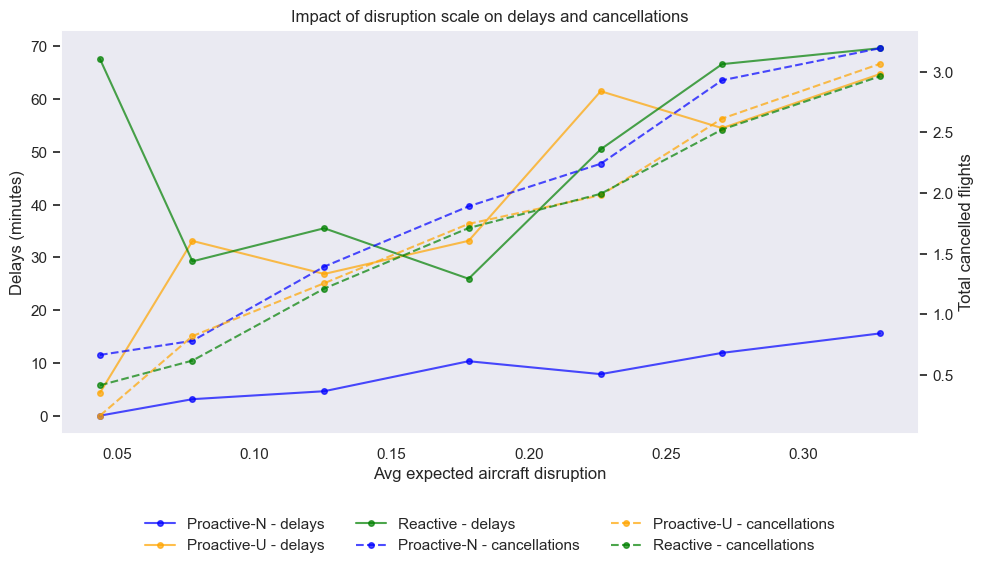

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("dark")

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()  # Create second y-axis sharing same x-axis

# Define bucket boundaries
buckets = np.arange(0, 1.05, 0.05)  # Creates buckets 0-0.05, 0.05-0.1, etc.

for model_name, (color, label) in model_colors.items():
    model_data = merged_df[merged_df['Model'] == model_name]
    
    # Initialize lists to store bucket averages
    x_means = []
    y_means = []
    y2_means = []
    
    # Calculate averages for each bucket
    for i in range(len(buckets)-1):
        bucket_data = model_data[
            (model_data['AvgAircraftProbability'] >= buckets[i]) & 
            (model_data['AvgAircraftProbability'] < buckets[i+1])
        ]
        
        if not bucket_data.empty:
            x_means.append(bucket_data['AvgAircraftProbability'].mean())
            y_means.append(bucket_data['TotalDelays'].mean())
            y2_means.append(bucket_data['TotalCancelledFlights'].mean())
    
    # Plot the bucket averages for TotalDelays on first y-axis with higher zorder
    ax1.plot(x_means, y_means,
             color=color,
             label=f"{label} - delays",
             marker='o',
             markersize=4,
             alpha=0.7,
             zorder=5)
             
    # Plot the bucket averages for TotalCancelledFlights on second y-axis with higher zorder
    ax2.plot(x_means, y2_means,
             color=color,
             label=f"{label} - cancellations",
             linestyle='--',
             marker='o',
             markersize=4,
             alpha=0.7,
             zorder=5)

ax1.set_xlabel("Avg expected aircraft disruption")
ax1.set_ylabel("Delays (minutes)")
ax2.set_ylabel("Total cancelled flights")

# Add legends for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(0.5, -0.25), loc='center', ncol=3, frameon=False)

plt.title("Impact of disruption scale on delays and cancellations")
plt.tight_layout()
plt.show()
